In [1]:
#https://colab.research.google.com/github/HandsOnLLM/Hands-On-Large-Language-Models/blob/main/chapter04/Chapter%204%20-%20Text%20Classification.ipynb

In [1]:
import torch
print(torch.cuda.is_available())
device = 'cuda'

True


In [2]:
#!pip install --upgrade datasets huggingface_hub

In [3]:
from datasets import load_dataset

In [4]:
data = load_dataset("rotten_tomatoes")
print(data)

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 8530
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 1066
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 1066
    })
})


In [7]:
# I need to implement my own BERT first

In [8]:
%load_ext autoreload
%autoreload 2

import sys
import os

# Assuming your notebook's working directory is set such that ../llm-tokenizer is reachable:
tokenizer_dir = os.path.abspath(os.path.join(os.getcwd(), '../'))
if tokenizer_dir not in sys.path:
    sys.path.insert(0, tokenizer_dir)

from BERT.model import BERT
from BERT.utils import load_checkpoint, LossLogs
import llm_tokenizer.BPETokenizer as BPETokenizer

Current device index: 0
Running on GPU: NVIDIA RTX A6000
GPU properties:
  - Compute Capability: 8.6
  - Total Memory: 47.54 GB
  - Multiprocessor Count: 84
  - Max Threads per Multiprocessor: 1536


In [9]:
from dataclasses import dataclass, field
import uuid
@dataclass
class BERTConfig:
    # model is going to be (BERT_batch_size, input_size, embedding_size or hidden_layer_size)
    BERT_batch_size = 64
    batch_size = BERT_batch_size * 2
    block_size = 40
    embedding_size = 256*2
    vocab_size = 2220 # new tokens: 2215, 2216, 2217, 2218 from dataloader
    input_size = 2 * block_size + 3
    hidden_layer_size = 1024
    attention_heads = 8
    attention_size = embedding_size // attention_heads
    train_epochs = 1000000
    val_epochs = 30
    val_interval = 100
    transformer_blocks = 10
    model_name: str = field(default_factory=lambda: f"BERT_{uuid.uuid4()}")
    checkpoint_interval = 1000

                            
config = BERTConfig() 

In [10]:
MLMloss = LossLogs("MLM", scale=0.1)
NSPloss = LossLogs("NSP")

In [60]:
model = BERT(config)
model.to(device)
model.eval()

BERT(
  (input_representation): InputRepresentation(
    (token_embeddings): Embedding(2220, 512)
    (segment_embeddings): Embedding(2, 512)
    (position_embeddings): Embedding(84, 512)
  )
  (transformer_blocks): ModuleList(
    (0-9): 10 x TransformerBlock(
      (attention): MultiHeadAttention(
        (heads): ModuleList(
          (0-7): 8 x SelfAttention(
            (key): Linear(in_features=512, out_features=64, bias=True)
            (query): Linear(in_features=512, out_features=64, bias=True)
            (value): Linear(in_features=512, out_features=64, bias=True)
          )
        )
        (linear): Linear(in_features=512, out_features=512, bias=True)
      )
      (mlp): ModuleList(
        (0): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
        (1): Linear(in_features=512, out_features=1024, bias=True)
        (2): ReLU()
        (3): Linear(in_features=1024, out_features=512, bias=True)
      )
      (attention_norm): LayerNorm((512,), eps=1e-05, elementwi

In [12]:
small_checkpoint = "../BERT/BERT_checkpoints/checkpoint_BERT_tinyshakespeare_10kepochs.pth"
big_checkpoint = "../BERT/BERT_checkpoints/checkpoint_BERT_wikitext2_6hours.pth"

# small checkpoint val losses
# 0.4528544922669729 2.3962665438652038
# epoch 90000

# big checkpoint val losses
# 0.17656663432717323 1.1264266490936279
# epoch 165000

In [44]:
load_checkpoint(
    model, 
    None, 
    big_checkpoint, 
    MLMloss, 
    NSPloss)

Checkpoint loaded from ../BERT/BERT_checkpoints/checkpoint_BERT_wikitext2_6hours.pth, resuming at epoch 165000


(165000, 'BERT_8123c751-bd44-43a9-820f-3abc980959e1')

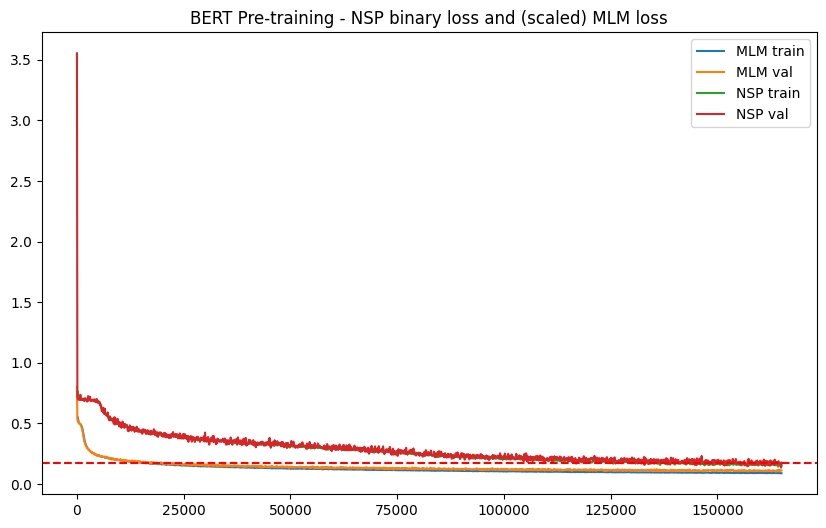

0.17656663432717323 1.1264266490936279


In [45]:
from matplotlib import pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(*MLMloss.train_loss_series(aggr=200), label="MLM train")
plt.plot(*MLMloss.val_loss_series(), label="MLM val")
plt.plot(*NSPloss.train_loss_series(aggr=200), label="NSP train")
plt.plot(*NSPloss.val_loss_series(), label="NSP val")
plt.legend()
plt.title("BERT Pre-training - NSP binary loss and (scaled) MLM loss")
plt.axhline(NSPloss.val_loss[-1], linestyle="--", color='r')
plt.show()
print(NSPloss.val_loss[-1], MLMloss.val_loss[-1])

In [15]:
import sys
sys.modules['BPETokenizer'] = BPETokenizer

In [47]:
tokenizer = BPETokenizer.Tokenizer(
    "", 
    encoding_vocab_size=2000, 
    name="wikitext2",
    path_prefix="../BERT/")
tokenizer.load_from_file()

In [48]:
max(tokenizer.encoding_map.values())

659

In [49]:
class ClassifierDataLoader():
    
    def __init__(self, embedding_model, device='cpu', text=None):
        self.embedding_model = embedding_model
        self.device = device
        self.tokenizer = BPETokenizer.Tokenizer(
            "", 
            encoding_vocab_size=2000, 
            name="wikitext2",
            path_prefix="../BERT/")
        self.tokenizer.load_from_file()
        self.max_vocab_size = max(self.tokenizer.encoding_map.values())
        self.CLS =self.max_vocab_size + 1
        self.SEP = self.CLS + 1
        self.MASK = self.SEP + 1

        self.text = text
        if text: 
            data = "".join(text)
            tokens = self.tokenizer.encode(data, raw_tokens=False)
            print(f"[ClassifierDataLoader] loaded tokenizer '{self.tokenizer._filename()}' with compression rate = {len(tokens)/len(list(data.encode('utf-8')))}")
            
            self.construct_embeddings(text)
        
    def construct_embeddings(self, xs):
        self.embeddings = []
        for ix, x in enumerate(xs):
            if ix % 1000 == 0: print(f"[ClassifierDataLoader] embedding inference {ix}/{len(xs)}")
            self.embeddings.append(self.embedding(x))
        self.embeddings = torch.stack(self.embeddings)
        return self.embeddings
        
        
    def embedding(self, x):
        tokens = self.tokenizer.encode(x, raw_tokens=False)
        tokens = [self.CLS] + tokens[:80] + [self.SEP]
        x = torch.tensor(tokens, device=self.device).view(1, -1)
        with torch.no_grad():
            CLS_embeddings = self.embedding_model(x)[0, 0, :]
        # try last sep token also?
        # try average pooling over all tokens
        return CLS_embeddings

In [61]:
train_data_loader = ClassifierDataLoader(model, device, data["train"]["text"])

[ClassifierDataLoader] loaded tokenizer '../BERT/tokenizer_wikitext2.pickle' with compression rate = 0.5086554934669895
[ClassifierDataLoader] embedding inference 0/8530
[ClassifierDataLoader] embedding inference 1000/8530
[ClassifierDataLoader] embedding inference 2000/8530
[ClassifierDataLoader] embedding inference 3000/8530
[ClassifierDataLoader] embedding inference 4000/8530
[ClassifierDataLoader] embedding inference 5000/8530
[ClassifierDataLoader] embedding inference 6000/8530
[ClassifierDataLoader] embedding inference 7000/8530
[ClassifierDataLoader] embedding inference 8000/8530


In [62]:
test_data_loader = ClassifierDataLoader(model, device, data["test"]["text"])

[ClassifierDataLoader] loaded tokenizer '../BERT/tokenizer_wikitext2.pickle' with compression rate = 0.5082970708579594
[ClassifierDataLoader] embedding inference 0/1066
[ClassifierDataLoader] embedding inference 1000/1066


In [63]:
from sklearn.linear_model import LogisticRegression

# Train a Logistic Regression on our train embeddings
clf = LogisticRegression(random_state=42)
clf.fit(train_data_loader.embeddings.cpu(), data["train"]["label"])

LogisticRegression(random_state=42)

In [54]:
from sklearn.metrics import classification_report

def evaluate_performance(y_true, y_pred):
    """Create and print the classification report"""
    performance = classification_report(
        y_true, y_pred,
        target_names=["Negative Review", "Positive Review"]
    )
    print(performance)

In [64]:
# Predict previously unseen instances
y_pred = clf.predict(test_data_loader.embeddings.cpu())
evaluate_performance(data["test"]["label"], y_pred)

                 precision    recall  f1-score   support

Negative Review       0.58      0.58      0.58       533
Positive Review       0.58      0.58      0.58       533

       accuracy                           0.58      1066
      macro avg       0.58      0.58      0.58      1066
   weighted avg       0.58      0.58      0.58      1066

